In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
dataset_path = os.listdir('/content/drive/MyDrive/Camera_classification/Dataset')

In [ ]:
print(dataset_path)

['Digital Camera', 'Phone']


In [ ]:
class_labels = []

for item in dataset_path:
  all_classes = os.listdir("/content/drive/MyDrive/Camera_classification/Dataset"+'/'+item)

  for room in all_classes:
    class_labels.append((item,str('dataset_path'+'/'+item)+'/'+ room))

In [ ]:
df = pd.DataFrame(data=class_labels,columns=["Labels","image"])
print(df.head())
print(df.tail())

           Labels                                              image
0  Digital Camera  dataset_path/Digital Camera/point-and-shoot-fi...
1  Digital Camera  dataset_path/Digital Camera/pexels-photo-41668...
2  Digital Camera  dataset_path/Digital Camera/FUJIFILM-USA-hero-...
3  Digital Camera  dataset_path/Digital Camera/Pre-Owned_3to2_174...
4  Digital Camera  dataset_path/Digital Camera/First-film-camera6...
     Labels                                              image
1318  Phone  dataset_path/Phone/Best-Smartphone-Camera-Rank...
1319  Phone      dataset_path/Phone/smartphone-camera-tips.jpg
1320  Phone               dataset_path/Phone/X-T30_DSF2302.jpg
1321  Phone  dataset_path/Phone/AndroidPIT-camera-test-comp...
1322  Phone  dataset_path/Phone/AndroidPIT-camera-blind-tes...


In [ ]:
print("Total number of images in the dataset: ",len(df))

label_count = df["Labels"].value_counts()
print(label_count)

Total number of images in the dataset:  1323
Digital Camera    762
Phone             561
Name: Labels, dtype: int64


In [ ]:
import cv2

In [ ]:
path = '/content/drive/MyDrive/Camera_classification/Dataset/'

dataset_path = os.listdir('/content/drive/MyDrive/Camera_classification/Dataset')

im_size = 224

images = []
labels = []

for i in dataset_path:
  data_path = path + str(i)
  filenames = [i for i in os.listdir(data_path)]

  for f in filenames:
    img = cv2.imread(data_path+'/'+f)
    img = cv2.resize(img,(im_size,im_size))
    images.append(img)
    labels.append(i)

In [ ]:
images = np.array(images)
images = images.astype('float32')/255.0
images.shape

(1323, 224, 224, 3)

In [ ]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder

y = df['Labels'].values
print(y)

y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)

['Digital Camera' 'Digital Camera' 'Digital Camera' ... 'Phone' 'Phone'
 'Phone']


In [ ]:
#np.save('/content/drive/MyDrive/Camera_classification/images_array',images)
#np.save('/content/drive/MyDrive/Camera_classification/labels_encoded',y)

In [ ]:
y = y.reshape(-1,1)

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([("my_ohe",OneHotEncoder(),[0])],remainder = 'passthrough')
Y = ct.fit_transform(y)
print(Y[:5])
print(Y[1320:])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
#np.save("/content/drive/MyDrive/Camera_classification/labels_onehot",Y)

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images , Y = shuffle(images,Y,random_state = 7)
train_x, test_x,train_y,test_y = train_test_split(images,Y,test_size = 0.25,random_state = 112)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(992, 224, 224, 3)
(992, 2)
(331, 224, 224, 3)
(331, 2)


In [ ]:
#np.save("/content/drive/MyDrive/Camera_classification/train_x_oh",train_x)
#np.save("/content/drive/MyDrive/Camera_classification/train_y_oh",train_y)
#np.save("/content/drive/MyDrive/Camera_classification/test_x_oh",test_x)
#np.save("/content/drive/MyDrive/Camera_classification/test_y_oh",test_y)

In [2]:
train_x =np.load("/content/drive/MyDrive/Camera_classification/train_x_oh.npy")
train_y = np.load("/content/drive/MyDrive/Camera_classification/train_y_oh.npy")
test_x =np.load("/content/drive/MyDrive/Camera_classification/test_x_oh.npy")
test_y = np.load("/content/drive/MyDrive/Camera_classification/test_y_oh.npy")

NameError: ignored

### Modeling 

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 2
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)

inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))

outputs = EfficientNetB0(include_top = True,weights = None,classes = NUM_CLASSES)(inputs)

In [ ]:
model = tf.keras.Model(inputs,outputs)

model.compile(optimizer='adam',loss = "categorical_crossentropy",metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 2)                4052133   
                                                                 
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
mc = ModelCheckpoint(filepath="/content/drive/MyDrive/Camera_classification/vgg_base.h5",
                     monitor = "val_accuracy",
                     verbose = 1,
                     save_best_only=True)

es = EarlyStopping(monitor="val_accuracy",
                   min_delta=0.01,
                   patience = 5,
                   verbose = 1)

cb = [mc,es]

In [ ]:
r = model.fit(
  train_x,train_y,
  validation_data=(test_x,test_y),
  epochs=20,
  callbacks = cb)

Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 3.0869 - accuracy: 0.5272
Epoch 1: val_accuracy improved from -inf to 0.56495, saving model to /content/drive/MyDrive/Camera_classification/vgg_base.h5
31/31 [==============================] - 33s 419ms/step - loss: 3.0869 - accuracy: 0.5272 - val_loss: 0.9579 - val_accuracy: 0.5650
Epoch 2/20
31/31 [==============================] - ETA: 0s - loss: 1.3686 - accuracy: 0.5907
Epoch 2: val_accuracy did not improve from 0.56495
31/31 [==============================] - 9s 303ms/step - loss: 1.3686 - accuracy: 0.5907 - val_loss: 0.9338 - val_accuracy: 0.5650
Epoch 3/20
31/31 [==============================] - ETA: 0s - loss: 1.4476 - accuracy: 0.6250
Epoch 3: val_accuracy did not improve from 0.56495
31/31 [==============================] - 9s 307ms/step - loss: 1.4476 - accuracy: 0.6250 - val_loss: 0.8887 - val_accuracy: 0.5650
Epoch 4/20
31/31 [==============================] - ETA: 0s - loss: 1.5411 - accuracy: 0.6663
Ep

In [ ]:
preds = model.evaluate(test_x,test_y)

print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

11/11 [==============================] - 1s 67ms/step - loss: 0.7854 - accuracy: 0.4350
Loss = 0.7853577136993408
Test Accuracy = 0.4350453317165375


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
inception = ResNet50V2(input_shape=(224,224,3), weights='imagenet', include_top=False)

94683136/94668760 [==============================] - 0s 0us/step


In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
from glob import glob
folders = glob('/content/drive/MyDrive/Camera_classification/Dataset/*')

In [ ]:
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [ ]:
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='sigmoid')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['accuracy']
)

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

mc = ModelCheckpoint(filepath="/content/drive/MyDrive/Camera_classification/resnet50v2.h5",
                     monitor = "val_accuracy",
                     verbose = 1,
                     save_best_only=True)

es = EarlyStopping(monitor="val_accuracy",
                   min_delta=0.01,
                   patience = 5,
                   verbose = 1)

cb = [mc,es]

In [ ]:
r = model.fit(
  train_x,train_y,
  validation_data=(test_x,test_y),
  epochs=20,
  callbacks = cb)

Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 1.3963 - accuracy: 0.9093
Epoch 1: val_accuracy improved from -inf to 0.90332, saving model to /content/drive/MyDrive/Camera_classification/resnet50v2.h5
31/31 [==============================] - 10s 201ms/step - loss: 1.3963 - accuracy: 0.9093 - val_loss: 2.1541 - val_accuracy: 0.9033
Epoch 2/20
31/31 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9829
Epoch 2: val_accuracy improved from 0.90332 to 0.95468, saving model to /content/drive/MyDrive/Camera_classification/resnet50v2.h5
31/31 [==============================] - 4s 137ms/step - loss: 0.2154 - accuracy: 0.9829 - val_loss: 1.2588 - val_accuracy: 0.9547
Epoch 3/20
31/31 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9960
Epoch 3: val_accuracy did not improve from 0.95468
31/31 [==============================] - 4s 115ms/step - loss: 0.0209 - accuracy: 0.9960 - val_loss: 1.4998 - val_accuracy: 0.9517
Epoch 4/20
31/

In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/Camera_classification/resnet50v2.h5")

In [ ]:
import urllib.request
import PIL
import numpy as np

urllib.request.urlretrieve("https://m.media-amazon.com/images/I/51+7Guk8aGL._SY355_.jpg","sample.png")
img = PIL.Image.open("sample.png").resize((224,224))
test_img = np.array(img).reshape(-1,224,224,3)

In [ ]:
model.predict(test_img)

array([[1., 1.]], dtype=float32)

In [ ]:
import tensorflow_hub as hub

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
mobile_net_layers = hub.KerasLayer(mobilenet_v2, input_shape=(224,224,3))

In [ ]:
mobile_net_layers.trainable = False


In [ ]:
import tensorflow as tf


In [ ]:
neural_net = tf.keras.Sequential([
  mobile_net_layers,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(2,activation='softmax')
])

In [ ]:
neural_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
neural_net.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

mc = ModelCheckpoint(filepath="/content/drive/MyDrive/Camera_classification/mobilenet_phone.h5",
                     monitor = "val_accuracy",
                     verbose = 1,
                     save_best_only=True)

es = EarlyStopping(monitor="val_accuracy",
                   min_delta=0.01,
                   patience = 5,
                   verbose = 1)

cb = [mc,es]

In [ ]:
train_x =np.load("/content/drive/MyDrive/Camera_classification/train_x_oh.npy")
train_y = np.load("/content/drive/MyDrive/Camera_classification/train_y_oh.npy")
test_x =np.load("/content/drive/MyDrive/Camera_classification/test_x_oh.npy")
test_y = np.load("/content/drive/MyDrive/Camera_classification/test_y_oh.npy")

In [ ]:
model_fit = neural_net.fit(train_x,train_y, epochs=6, validation_data=(test_x,test_y),callbacks = cb)

Epoch 1/6


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


31/31 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.8397
Epoch 1: val_accuracy improved from -inf to 0.94562, saving model to /content/drive/MyDrive/Camera_classification/mobilenet_phone.h5
31/31 [==============================] - 7s 98ms/step - loss: 0.3559 - accuracy: 0.8397 - val_loss: 0.1475 - val_accuracy: 0.9456
Epoch 2/6
31/31 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9496
Epoch 2: val_accuracy did not improve from 0.94562
31/31 [==============================] - 2s 55ms/step - loss: 0.1309 - accuracy: 0.9496 - val_loss: 0.1296 - val_accuracy: 0.9456
Epoch 3/6
31/31 [==============================] - ETA: 0s - loss: 0.0980 - accuracy: 0.9677
Epoch 3: val_accuracy improved from 0.94562 to 0.95468, saving model to /content/drive/MyDrive/Camera_classification/mobilenet_phone.h5
31/31 [==============================] - 2s 65ms/step - loss: 0.0980 - accuracy: 0.9677 - val_loss: 0.1150 - val_accuracy: 0.9547
Epoch 4/6
31/31 [====

In [ ]:
test_score=neural_net.evaluate(test_x,test_y)

11/11 [==============================] - 1s 46ms/step - loss: 0.1167 - accuracy: 0.9577


In [ ]:
import pickle as pkl
pkl.dump(neural_net,open("/content/drive/MyDrive/Camera_classification/mobilenet_pickle_final.pkl","wb"))

In [3]:
import pickle as pkl
model_new = pkl.load(open("/content/drive/MyDrive/Camera_classification/mobilenet_pickle_final.pkl","rb"))

In [26]:
import urllib.request
import PIL
import numpy as np
import matplotlib.pyplot as plt

urllib.request.urlretrieve("https://venturebeat.com/product-comparisons?wp-content=uploads/2021/04/Digital-Camera-2021.jpeg","sample.png")
img = PIL.Image.open("sample.png").resize((224,224))
test_img = np.array(img).reshape(-1,224,224,3)

In [24]:
make_predictions =model_new.predict(test_img)

In [6]:
labels = ["Digital Camera", "Phone"]

[[0.8540939  0.14590614]]


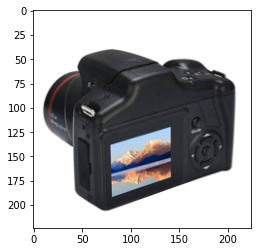

: Digital Camera


In [27]:
print(make_predictions)
plt.figure()
plt.imshow(img)
plt.show()
print(": %s" % labels[np.argmax(make_predictions)])